In [54]:
import os
import random
import re
from tqdm.notebook import tqdm
from collections import Counter

import numpy as np
import pandas as pd

import category_encoders as ce
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

import seaborn as sns
import matplotlib.pyplot as plt

ROOT_DIR = "./data"
RANDOM_SEED = 110

np.random.seed(RANDOM_SEED)
%matplotlib inline

pd.options.display.max_columns = 200

In [55]:
# read csv
df_tr = pd.read_csv(os.path.join(ROOT_DIR, "train_v1.csv"))
df_te = pd.read_csv(os.path.join(ROOT_DIR, "test_v1.csv"))
df_list = [df_tr, df_te]

In [56]:
for df in df_list:
    df.drop(["Workorder"], axis=1, inplace=True)

### Scaling & Encoding

In [57]:
cat_features = ["Equipment_Dam",
                "Equipment_Fill1",
                "Equipment_Fill2",
                "Model.Suffix",
                # "Workorder",
                "Workorder Category",
                "Chamber Temp. Judge Value_AutoClave"]

# 여기서 Workorder 빼기로 함

bins_features = df_tr.columns[df_tr.columns.str.contains(r".*Bins.*")].tolist()
from_bins_features = [re.sub(r'\s*Bins\s*', '', f).strip() for f in bins_features]

cat_features.extend(bins_features)

In [58]:
for df in df_list:
    df[cat_features] = df[cat_features].astype("category")

In [59]:
num_features = df_tr.select_dtypes(exclude=["category"]).columns.to_list()
num_features.remove("target")

all_features = num_features + cat_features

In [60]:
# 우리가 파악해야하는 건 AbNormal이므로 1로 설정
df_tr["target"] = df_tr["target"].map({"Normal": 0, "AbNormal": 1})
# df_tr["target"] = df_tr["target"].map({0:"Normal", 1:"AbNormal"})

In [61]:
X_tr = df_tr.drop("target", axis=1)
y_tr = df_tr["target"]

X_te = df_te.drop("Set ID", axis=1)
set_id = df_te["Set ID"]

In [62]:
# ct = make_column_transformer(
#     (OneHotEncoder(handle_unknown="ignore", sparse=False), cat_features),
#     (MinMaxScaler(), num_features),
#     remainder="passthrough",
# )

le = LabelEncoder()

for cat_feature in cat_features:
    X_tr[cat_feature] = le.fit_transform(X_tr[cat_feature])
    X_te[cat_feature] = le.transform(X_te[cat_feature])
   

mms = MinMaxScaler()

X_tr[num_features] = mms.fit_transform(X_tr[num_features])
X_te[num_features] = mms.transform(X_te[num_features])

In [63]:
X_tr.head()

,Equipment_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam,HEAD Standby Position X Collect Result_Dam,HEAD Standby Position Y Collect Result_Dam,HEAD Standby Position Z Collect Result_Dam,Head Clean Position X Collect Result_Dam,Head Clean Position Y Collect Result_Dam,Head Clean Position Z Collect Result_Dam,Head Purge Position X Collect Result_Dam,Head Purge Position Y Collect Result_Dam,Head Purge Position Z Collect Result_Dam,Head Zero Position X Collect Result_Dam,Head Zero Position Y Collect Result_Dam,Head Zero Position Z Collect Result_Dam,Machine Tact time Collect Result_Dam,PalletID Collect Result_Dam,Production Qty Collect Result_Dam,Receip No Collect Result_Dam,Stage1 Circle1 Distance Speed Collect Result_Dam,Stage1 Circle2 Distance Speed Collect Result_Dam,Stage1 Line1 Distance Speed Collect Result_Dam,Stage1 Line2 Distance Speed Collect Result_Dam,Stage1 Line3 Distance Speed Collect Result_Dam,Stage1 Line4 Distance Speed Collect Result_Dam,Stage2 Circle1 Distance Speed Collect Result_Dam,Stage2 Circle2 Distance Speed Collect Result_Dam,Stage2 Line1 Distance Speed Collect Result_Dam,Stage2 Line2 Distance Speed Collect Result_Dam,Stage2 Line3 Distance Speed Collect Result_Dam,Stage2 Line4 Distance Speed Collect Result_Dam,Stage3 Circle1 Distance Speed Collect Result_Dam,Stage3 Circle2 Distance Speed Collect Result_Dam,Stage3 Line1 Distance Speed Collect Result_Dam,Stage3 Line2 Distance Speed Collect Result_Dam,Stage3 Line3 Distance Speed Collect Result_Dam,Stage3 Line4 Distance Speed Collect Result_Dam,THICKNESS 1 Collect Result_Dam,THICKNESS 2 Collect Result_Dam,THICKNESS 3 Collect Result_Dam,WorkMode Collect Result_Dam,1st Pressure Collect Result_AutoClave,1st Pressure Unit Time_AutoClave,2nd Pressure Collect Result_AutoClave,2nd Pressure Unit Time_AutoClave,3rd Pressure Collect Result_AutoClave,3rd Pressure Unit Time_AutoClave,Chamber Temp. Collect Result_AutoClave,Chamber Temp. Unit Time_AutoClave,Chamber Temp. Judge Value_AutoClave,Equipment_Fill1,DISCHARGED SPEED OF RESIN Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1,Dispense Volume(Stage1) Collect Result_Fill1,Dispense Volume(Stage2) Collect Result_Fill1,Dispense Volume(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1,HEAD Standby Position X Collect Result_Fill1,HEAD Standby Position Y Collect Result_Fill1,HEAD Standby Position Z Collect Result_Fill1,Head Clean Position X Collect Result_Fill1,Head Clean Position Y Collect Result_Fill1,Head Clean Position Z Collect Re

### Resampling

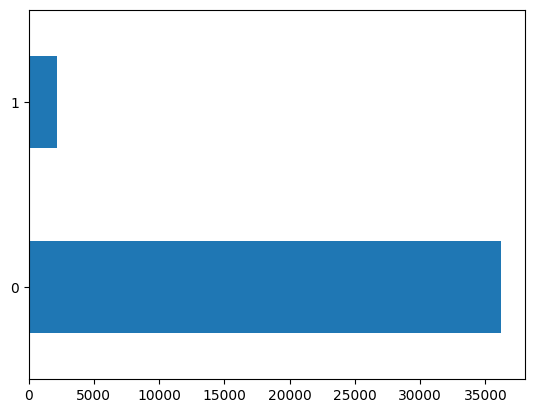

In [64]:
df_tr["target"].value_counts().plot(kind="barh");

In [65]:
def viz_pie(df):
    df["target"].value_counts().plot.pie(labels=["Normal", "AbNormal"], autopct=lambda x:f"{x:.2f}%");

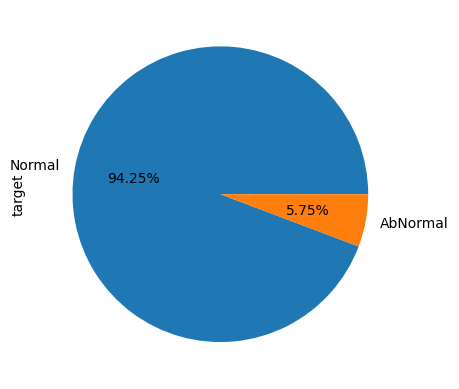

In [66]:
viz_pie(df_tr)

In [67]:
# ohe = ct.transformers_[0][1]
# ohe_cat_features = ohe.get_feature_names_out(cat_features)
# ohe_all_features = num_features + list(ohe_cat_features)

In [68]:
from sklearn.utils import resample
from imblearn.under_sampling import (NearMiss,
                                     ClusterCentroids,
                                     AllKNN,
                                     OneSidedSelection,
                                     TomekLinks)
from imblearn.over_sampling import (RandomOverSampler,
                                    SMOTE,
                                    ADASYN,
                                    SMOTENC,
                                    BorderlineSMOTE,
                                    KMeansSMOTE)

from imblearn.combine import SMOTEENN

def random_downsample(df, sample_ratio=1.0, random_seed=RANDOM_SEED):
    df_normal = df[df["target"] == 0] 
    df_abnormal = df[df["target"] == 1]
    
    downsampled = resample(
        df_normal,
        replace=False,
        n_samples=int(len(df_abnormal) * sample_ratio),
        random_state=random_seed
    )
    
    downsampled_df = pd.concat([df_abnormal, downsampled])
    
    return downsampled_df

def downsample(X, y, method, random_seed=RANDOM_SEED):
    # NearMiss
    if method == "nearmiss":
        # sampling_strategy="auto"
        nm = NearMiss(sampling_strategy=0.4)
        X_downsampled, y_downsampled = nm.fit_resample(X, y)
    # ClusterCentroids
    elif method == "cluster":
        cc = ClusterCentroids(random_state=random_seed)
        X_downsampled, y_downsampled = cc.fit_resample(X, y)
    # AllKNN
    elif method == "allknn":
        allknn = AllKNN()
        X_downsampled, y_downsampled = allknn.fit_resample(X, y)
    # OneSidedSelection
    elif method == "oneside":
        oss = OneSidedSelection(random_state=random_seed)
        X_downsampled, y_downsampled = oss.fit_resample(X, y)
    # Tomeklinks
    elif method == "tomek":
        tl = TomekLinks()
        X_downsampled, y_downsampled = tl.fit_resample(X, y)
    
    X_downsampled_df= pd.DataFrame(X_downsampled, columns=all_features)
    y_downsampled_df = pd.Series(y_downsampled, name="target") 
    downsampled_df = pd.concat([X_downsampled_df, y_downsampled_df], axis=1)
    
    print('Original dataset shape %s' % Counter(y))
    print('Resampled dataset shape %s' % Counter(y_downsampled))
    
    return downsampled_df 

def upsample(X, y, cat_idx, method, random_seed=RANDOM_SEED):
    # X = df.drop("target", axis=1)
    # y = df["target"]
    
    if method == "random":
        ros = RandomOverSampler(random_state=random_seed)
        X_upsampled, y_upsampled = ros.fit_resample(X, y)
    # SMOTE
    if method == "smote":
        smote = SMOTE(random_state=random_seed)
        X_upsampled, y_upsampled = smote.fit_resample(X, y)
    # ADASYN
    elif method == "adasyn":
        adasyn = ADASYN(random_state=random_seed)
        X_upsampled, y_upsampled = adasyn.fit_resample(X, y)
    # SMOTE-NC (both numerical & categorical features)
    elif method == "smotenc":
        smotenc = SMOTENC(random_state=random_seed, sampling_strategy="auto", categorical_features=cat_idx)
        X_upsampled, y_upsampled = smotenc.fit_resample(X, y)
    elif method == "borderline":
        borderline_smote = BorderlineSMOTE(random_state=random_seed)
        X_upsampled, y_upsampled = borderline_smote.fit_resample(X, y)
    elif method == "kmeans":
        kmeans_smote = KMeansSMOTE(random_state=random_seed)
        X_upsampled, y_upsampled = kmeans_smote.fit_resample(X, y)
        
    X_upsampled_df= pd.DataFrame(X_upsampled, columns=X_tr.columns)
    y_upsampled_df = pd.Series(y_upsampled, name="target") 
    upsampled_df = pd.concat([X_upsampled_df, y_upsampled_df], axis=1)
    
    print('Original dataset shape %s' % Counter(y))
    print('Resampled dataset shape %s' % Counter(y_upsampled))
    
    return upsampled_df

In [69]:
# downsampled_df = random_downsample(df, sample_ratio=3.0)
downsample_options = {1:"nearmiss", 2:"cluster", 3:"allknn", 4:"oneside", 5:"tomek"}

downsampled_df_tr = downsample(X_tr, y_tr, method=downsample_options[1])

Original dataset shape Counter({0: 36197, 1: 2210})
Resampled dataset shape Counter({0: 3157, 1: 2210})


In [70]:
downsampled_df_tr.columns[downsampled_df_tr.isnull().any()]

Index([], dtype='object')

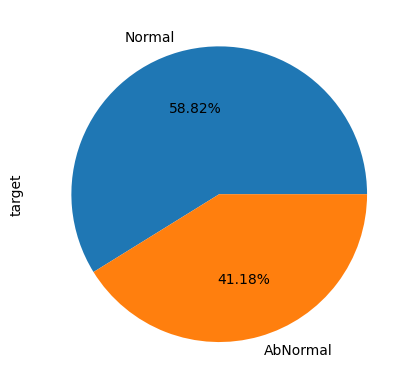

In [71]:
viz_pie(downsampled_df_tr)

In [72]:
upsample_options = {1: "random", 2:"smote", 3:"adasyn", 4:"smotenc", 5:"borderline", 6:"kmeans"}

cat_idx = [downsampled_df_tr.columns.get_loc(col) for col in cat_features]
X_tr = downsampled_df_tr.drop("target", axis=1)
y_tr = downsampled_df_tr["target"]

upsampled_df_tr = upsample(X_tr, y_tr, cat_idx, method=upsample_options[4])
# Counter(upsampled_df_tr['target'])

Original dataset shape Counter({0: 3157, 1: 2210})
Resampled dataset shape Counter({0: 3157, 1: 3157})


In [73]:
upsampled_df_tr.columns[downsampled_df_tr.isnull().any()]

Index([], dtype='object')

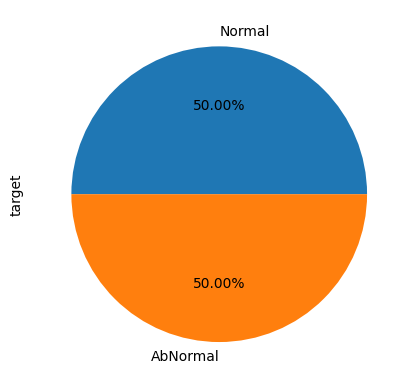

In [74]:
viz_pie(upsampled_df_tr)

In [75]:
X_tr = upsampled_df_tr.drop("target", axis=1)
y_tr = upsampled_df_tr["target"]

# X_tr = downsampled_df_tr.drop("target", axis=1)
# y_tr = downsampled_df_tr["target"]

### Feature Selection / Classification

In [76]:
from sklearn.feature_selection import RFE, SelectFromModel, SelectKBest, f_classif, chi2
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score, precision_score, recall_score

import optuna
import warnings
warnings.filterwarnings('ignore')

In [77]:
classifiers = {
    "cat": CatBoostClassifier(random_state=RANDOM_SEED, auto_class_weights="Balanced"),
    "lgbm": LGBMClassifier(random_state=RANDOM_SEED, metric=""),
    "xgb": XGBClassifier(random_state=RANDOM_SEED, eval_metric='auc', objective="binary:logistic"),
    "ada": AdaBoostClassifier(random_state=RANDOM_SEED),
    "rfc": RandomForestClassifier(random_state=RANDOM_SEED, class_weight='balanced'),
    "lr": LogisticRegression(random_state=RANDOM_SEED),
}

log_cols = ["model", "resample", "f1", "aucroc", "precision", "recall", "accuracy"]
log = pd.DataFrame(columns=log_cols)

K = 5
DOWN = "AllKNN"
UP = "SMOTENC"
RESAMPLE = f"{DOWN}-{UP}"

def get_log(clf, X, y):
    y_prob = clf.predict_proba(X)
    y_pred = clf.predict(X)
    
    clf_name = clf.__class__.__name__
    f1 = f1_score(y,y_pred)
    aucroc = roc_auc_score(y, y_prob[:,1])
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    acc = accuracy_score(y, y_pred)
    
    tmp_log = [clf_name, RESAMPLE, f1, aucroc, precision, recall, acc]
    # log = pd.concat([log, tmp_log], ignore_index=True)
    
    # print(classification_report(y, y_pred))
    
    return tmp_log

In [78]:
model = classifiers["rfc"]
model.fit(X_tr, y_tr)

rfe = RFE(estimator=model, n_features_to_select=50)                                 
sfm = SelectFromModel(estimator=model, threshold="mean")
kbest = SelectKBest(score_func=f_classif,)

# X_tr_selec = sfm.fit_transform(X_tr, y_tr)
# X_te_selec = sfm.transform(X_te)

# 수동
selected_features = [feature for feature in all_features if feature not in from_bins_features] # 기존 열 대신 Bins 열 사용
X_tr_selec = X_tr[selected_features]
X_te_selec = X_te[selected_features]

print("Before ", X_tr.shape[1])
print("After ", X_tr_selec.shape[1])

Before  173
After  131


In [79]:
print("Before ", X_tr.shape[1])
print("After ", X_tr_selec.shape[1])

Before  173
After  131


### Model Check

In [80]:
stk = StratifiedKFold(n_splits=K, random_state=RANDOM_SEED, shuffle=True)
rstk = RepeatedStratifiedKFold(n_splits=K, random_state=RANDOM_SEED)

classifiers_lst = list(classifiers.values())

# 기본 확인
score_dic = {}
for clf_name, clf in classifiers.items():
    scores = cross_val_score(clf, X_tr_selec, y_tr, scoring="f1", cv=stk)
    score_dic[clf_name] = scores.mean()

Learning rate set to 0.020572
0:	learn: 0.6852722	total: 18.4ms	remaining: 18.4s
1:	learn: 0.6776193	total: 29.5ms	remaining: 14.7s
2:	learn: 0.6706631	total: 43.3ms	remaining: 14.4s
3:	learn: 0.6641781	total: 57.5ms	remaining: 14.3s
4:	learn: 0.6580599	total: 67.7ms	remaining: 13.5s
5:	learn: 0.6517533	total: 82.9ms	remaining: 13.7s
6:	learn: 0.6464497	total: 95.3ms	remaining: 13.5s
7:	learn: 0.6410016	total: 110ms	remaining: 13.7s
8:	learn: 0.6354205	total: 124ms	remaining: 13.7s
9:	learn: 0.6301347	total: 132ms	remaining: 13.1s
10:	learn: 0.6256696	total: 146ms	remaining: 13.1s
11:	learn: 0.6210552	total: 161ms	remaining: 13.3s
12:	learn: 0.6164068	total: 174ms	remaining: 13.2s
13:	learn: 0.6125098	total: 182ms	remaining: 12.8s
14:	learn: 0.6084552	total: 194ms	remaining: 12.8s
15:	learn: 0.6047583	total: 208ms	remaining: 12.8s
16:	learn: 0.6009859	total: 226ms	remaining: 13.1s
17:	learn: 0.5978612	total: 238ms	remaining: 13s
18:	learn: 0.5948697	total: 251ms	remaining: 12.9s
19:	le

In [81]:
score_dic

{'cat': 0.8279687503350642,
 'lgbm': 0.82180052052144,
 'xgb': 0.8236500255537207,
 'ada': 0.745820363055171,
 'rfc': 0.7887340838555257,
 'lr': 0.7257203921127179}

### Tuning

In [ ]:
# def catboost_objective(trial, X_tr, y_tr, X_val, y_val):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1100),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.3),
#         'max_depth': trial.suggest_int('max_depth', 3, 15),
#         'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
#         'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.5, 1.0),
#     }

#     cat_clf = CatBoostClassifier(**params, random_state=RANDOM_SEED, auto_class_weights="Balanced", eval_metric = "f1")
#     cat_clf.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], early_stopping_rounds=20, verbose=False)

#     y_pred = cat_clf.predict(X_val)
    
#     f1 = f1_score(y_val, y_pred)

#     return f1

# cat_study = optuna.create_study(direction='maximize')
# cat_study.optimize(catboost_objective, n_trials=15)

# cat_best_params = cat_study.best_params
# cat_best_score = cat_study.best_value
# print("CatBoost Best Hyperparams: ", cat_best_params)
# print("CatBoost Best F1 Score: ", cat_best_score)

In [ ]:
# def lgbm_objective(trial, X_tr, y_tr, X_val, y_val):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
#         'max_depth': trial.suggest_int('max_depth', 5, 20),
#         'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
#         'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
#     }
    
#     lgbm_clf = LGBMClassifier(**params,metric="f1", eval_set=[(X_val, y_val)], early_stopping_rounds=100)
#     lgbm_clf.fit(X_tr, y_tr)
#     y_pred = lgbm_clf.predict(X_val)
    
#     f1 = f1_score(y_val, y_pred)
    
#     return f1
    
# study = optuna.create_study(direction='maximize')
# study.optimize(lgbm_objective, n_trials=15)

# lgbm_best_params = study.best_params
# lgbm_best_score= study.best_value
# print("LGBM Best Hyperparams: ",lgbm_best_params)
# print("LGBM Best F1 Score: ", lgbm_best_score)

In [ ]:
# for idx, (tr_idx, val_idx) in enumerate(cv.split(X_tr_selec, y_tr)):
#     X_tr_fold, X_val_fold = X_tr.iloc[tr_idx], X_tr.iloc[val_idx]
#     y_tr_fold, y_val_fold = y_tr.iloc[tr_idx], y_tr.iloc[val_idx]
    
#     clf.fit(X_tr_fold, y_tr_fold)
#     tmp_log = get_log(clf, X_val_fold, y_val_fold)

### Submission

In [83]:
final_clf = classifiers["cat"]
# final_clf = LGBMClassifier(**lgbm_best_params, random_state=RANDOM_SEED)

final_clf.fit(X_tr_selec, y_tr)
final_preds = final_clf.predict(X_te_selec)

Learning rate set to 0.022629
0:	learn: 0.6843102	total: 14.5ms	remaining: 14.5s
1:	learn: 0.6756340	total: 25.8ms	remaining: 12.9s
2:	learn: 0.6681328	total: 40.7ms	remaining: 13.5s
3:	learn: 0.6608244	total: 59.6ms	remaining: 14.8s
4:	learn: 0.6541826	total: 74.5ms	remaining: 14.8s
5:	learn: 0.6473711	total: 86.2ms	remaining: 14.3s
6:	learn: 0.6409550	total: 98.7ms	remaining: 14s
7:	learn: 0.6353150	total: 108ms	remaining: 13.3s
8:	learn: 0.6293132	total: 121ms	remaining: 13.3s
9:	learn: 0.6233424	total: 133ms	remaining: 13.1s
10:	learn: 0.6186523	total: 140ms	remaining: 12.6s
11:	learn: 0.6137411	total: 150ms	remaining: 12.4s
12:	learn: 0.6089890	total: 157ms	remaining: 11.9s
13:	learn: 0.6049464	total: 167ms	remaining: 11.8s
14:	learn: 0.6003857	total: 174ms	remaining: 11.4s
15:	learn: 0.5958750	total: 189ms	remaining: 11.6s
16:	learn: 0.5923088	total: 202ms	remaining: 11.7s
17:	learn: 0.5891153	total: 215ms	remaining: 11.7s
18:	learn: 0.5861713	total: 228ms	remaining: 11.8s
19:	le

In [85]:
df_sub = pd.read_csv(os.path.join(ROOT_DIR, "submission.csv"))
df_sub["target"] = final_preds
df_sub["target"] = df_sub["target"].map({0:"Normal", 1:"AbNormal"})
df_sub["target"].value_counts()

AbNormal    13602
Normal       3759
Name: target, dtype: int64

In [86]:
from datetime import datetime

curr_date = datetime.now().strftime("%m-%d_%H-%M-%S")
df_sub.to_csv(os.path.join(ROOT_DIR, f"submission_{curr_date}.csv"))